In [1]:
"""
OBJETIVO : Realizar el QC de SENAMHI en los datos, con la finalidad de
           identificar los datos erroneos, conformes y dudosos correctamente.
"""
Autor='Diego Paredes'

In [ ]:
# Graficos y visualizaciones
import matplotlib.pyplot as plt

# Liberias para manejo de datos
import pandas as pd
import numpy as np

# Liberias estandar
import time
import os

In [ ]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [ ]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 
imagenTest = 'D:/GOES/C13/2020/03/G16_C13_Cyl_20200320-2000.nc'
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'

#Variables generales
products = ['C07','C08','C13']

#!El '00' debe ir al final!
times = ['10','20','30','40','50','00']

In [ ]:
# Solo se usa una vez, para cambiar el nombre de los archivos 
# Coloca como nuevo nombre el codigo de la estacion, para facilitar su uso
def changeUmbralesFileName(DUmbrales):
    FUmbrales = os.listdir(DUmbrales)
    start_time = time.time()
    errors = []
    for umbName in FUmbrales:
        tempUmb = pd.read_csv(f'{DUmbrales}/{umbName}', nrows=5, sep=';')
        try:
            os.rename(f'{DUmbrales}/{umbName}', f'{DUmbrales}/UMBRAL-{tempUmb["IDESTACION"][0]}.csv')
        except:
            errors.append(tempUmb)
    
    print(f'Cantidad de archivos procesados:       {len(FUmbrales)}')
    print(f'Archivos que no se pudieron renombrar: {len(errors)}')
    print(f"Tiempo tomado en renombrar:             %.5fs" % (time.time() - start_time))
    return errors
    

In [ ]:
"""
Clasificacion V2
 - NC
 - ND
 - M01
 - D01
 - D02
 - C01 
"""
# Devuelve el nuevo flag V2 de una fila X
def getFlagV2(x, umbrales):
    dato = x['PRECIPITACION']
    
    # No existe dato
    if pd.isna(dato):
        return 'ND'
    
    # Test DUROS
    elif dato<0 or dato>=401:
        return 'M01'
    
    codigo = str(x['CODIGO'])
    mes =  int(x['FECHA'].split('/')[1]) -1
    hora = int(x['HORA'].split(':')[0])
    
    if not codigo in list(umbrales.keys()):
        val1 = -1
        val2 = -1
    else:
        val1 = umbrales[codigo][mes][hora][0]
        val2 = umbrales[codigo][mes][hora][1]
    
    # No existe umbrales
    if (val1==-1) and (val2==-1):
        return 'NC'
    
    
    # Umbral 2
    if dato > val2:
        return 'D02'
    
    # Umbral 1
    if dato > val1:
        return 'D01'       
    
    # Conforme    
    return 'C01'
    

In [ ]:
# Genera el FlagV2 para todo una lista de archivos de DataFrame (listDS)
def applyFlagV2(listDS, umbrales):
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    for name in listDS:
        try:
            df.append(pd.read_csv(name,encoding='latin-1'))   
        except:
            print(f'No se pudo leer el archivo {name} de dataset')
            return -1
        
    if len(df)>1:
        dsCompleto =  pd.concat(df, ignore_index=True) 
    else:
        dsCompleto =  df[0]
        
    print("Tiempo tomadoen leer los archivos: %.2fs" % (time.time() - start_time))
    
    
    
    dsCompleto['FLAGV2'] = dsCompleto.apply(lambda x: getFlagV2(x, umbrales),axis=1)
    
    print("Tiempo tomado en procesar el dataset: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    
    return dsCompleto
    

In [ ]:
# Reune todos los umbrales de los diferentes archivos en un solo diccionario
# Devuelve el diccionario, la lista con estaciones sin umbral y los errores
def getUmbralesResumen(DUmbrales,verb=20):
    umbrales = {}
    errors = []
    noMayor = []
    FUmbrales = os.listdir(DUmbrales)
    completos = 0
    
    start_time = time.time()
    print(f'Se procesaran  {len(FUmbrales)} archivos ...')    
    for files in FUmbrales:
        if not completos % verb:
            print("Progreso: %.2f %s en %.2fs"%(completos/len(FUmbrales)*100, '%',time.time() - start_time))
            
        dfUmb = pd.read_csv(f'{DUmbrales}/{files}', sep=';')
        codigo = str(dfUmb["IDESTACION"][0])
        umbrales[codigo] = [[[-1,-1] for j in range(24)] for e in range(12)]
        
        n = 0
        months = {0:'ENERO',1:'FEBRERO',2:'MARZO',3:'ABRIL',4:'MAYO',5:'JUNIO',6:'JULIO',
                  7:'AGOSTO',8:'SETIEMBRE',9:'OCTUBRE',10:'NOVIEMBRE',11:'DICIEMBRE'}
        for i in dfUmb.index:
            month = months[int(n/24)]
            hour = f'{int(n%24)}:00:00'              
            if month==dfUmb['DETALLEPERIODO'][i] and hour == dfUmb['DETHORA'][i]:
                umbrales[codigo][int(n/24)][int(n%24)][0] = dfUmb['VALORMAXIMO1'][i]
                umbrales[codigo][int(n/24)][int(n%24)][1] = dfUmb['VALORMAXIMO2'][i]
                
                # Verificamos que el umbral 2 sea mayor al 1
                if dfUmb['VALORMAXIMO2'][i] < dfUmb['VALORMAXIMO1'][i]:
                    noMayor.append(f'{codigo}-{i}')
            else:
                errors.append(f'{codigo}-{i}')
                
            n=n+1
        completos = completos + 1
        
    print("Tiempo total tomado: %.2fs" % (time.time() - start_time))
    print(f'Umbrales con valmax1 mayor a valmax2:  {len(noMayor)}')    
    print(f'Umbrales que no se encontraron:        {len(errors)}')        
    return umbrales, noMayor, errors        

In [36]:
# Nombre de los archivos a usar
Fdatos2021 = r'C:\Users\Shounen\Desktop\imagenes_tesis\val_nuevo.csv' #f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
#Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'

DUmbrales = f'{path_base}/Archivos/Inicial/UMBRALES/'

In [37]:
%%time
# Resume de los flags por estacion
dfUmbrales = {'Codigo':[],'Umbral1':[], 'Umbral2':[], 'min1' :[], 'min2':[]}
FUmbrales = os.listdir(DUmbrales)
for fileU in FUmbrales:
    tempUmb = pd.read_csv(f'{DUmbrales}{fileU}',sep=';')
    dfUmbrales['Codigo'].append(tempUmb['IDESTACION'][0])
    dfUmbrales['min1'].append(tempUmb['VALORMINIMO1'].max())
    dfUmbrales['min2'].append(tempUmb['VALORMINIMO2'].max())  
    dfUmbrales['Umbral1'].append(tempUmb['VALORMAXIMO1'].max())
    dfUmbrales['Umbral2'].append(tempUmb['VALORMAXIMO2'].max())  
    
dfUmbrales = pd.DataFrame(dfUmbrales)
dfUmbrales.to_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_umbrales.csv',index=False)
dfUmbrales

CPU times: total: 500 ms
Wall time: 498 ms


Codigo  Umbral1  Umbral2  min1  min2
0      107131      8.9     17.9     0     0
1      109091      3.6      8.3     0     0
2      109093      3.7     21.2     0     0
3      109096      0.4      0.5     0     0
4      110137      2.2      4.6     0     0
..        ...      ...      ...   ...   ...
214  47E880E2      4.2     24.0     0     0
215  47E89394      2.2     37.5     0     0
216  47E8B578      1.8      4.7     0     0
217  47E9177A      2.2     11.2     0     0
218  47E94706      0.5      5.7     0     0

[219 rows x 5 columns]

In [12]:
dfUmbrales

Codigo  Umbral1  Umbral2  min1  min2
0      107131      8.9     17.9     0     0
1      109091      3.6      8.3     0     0
2      109093      3.7     21.2     0     0
3      109096      0.4      0.5     0     0
4      110137      2.2      4.6     0     0
..        ...      ...      ...   ...   ...
214  47E880E2      4.2     24.0     0     0
215  47E89394      2.2     37.5     0     0
216  47E8B578      1.8      4.7     0     0
217  47E9177A      2.2     11.2     0     0
218  47E94706      0.5      5.7     0     0

[219 rows x 5 columns]

In [13]:
dfUmbrales['Umbral2'].min()

0.0

In [14]:
#dfUmbrales
dfEstaciones = pd.read_csv(Festaciones, index_col=1)
dfEstaciones.head(2)

Unnamed: 0    ESTACION       LON      LAT    ALT
CODE                                                       
X47E0D438           0      ALAMOR -80.39788 -4.48047  116.0
X47E09732           1  LA ARDILLA -80.39014 -4.48956  116.0

In [15]:
dfUmbrales['CODE'] = 'X' + dfUmbrales['Codigo'].astype(str)
dfUmbrales.set_index('CODE', inplace=True)
dfUmbrales.head(2)

Codigo  Umbral1  Umbral2  min1  min2
CODE                                         
X107131  107131      8.9     17.9     0     0
X109091  109091      3.6      8.3     0     0

In [16]:

_dfJoined = pd.concat([dfEstaciones, dfUmbrales], axis=1)
_dfJoined.to_csv(f'{path_base}/Archivos/Reportes/Datos/stations_data.csv')
_dfJoined.head(2)

Unnamed: 0    ESTACION       LON      LAT    ALT    Codigo  \
CODE                                                                    
X47E0D438         0.0      ALAMOR -80.39788 -4.48047  116.0  47E0D438   
X47E09732         1.0  LA ARDILLA -80.39014 -4.48956  116.0  47E09732   

           Umbral1  Umbral2  min1  min2  
CODE                                     
X47E0D438      9.3     10.2   0.0   0.0  
X47E09732      3.1     16.9   0.0   0.0

In [17]:
def plotMapPrecip(df2, tipo='TP'):   
    """
    Graficamos
    """
    #_df =df2[df2[tipo]==1]
    fig = px.scatter_mapbox(df2, lat="LAT", lon="LON", hover_data=['ESTACION'],                            
                            color = 'Umbral2',
                            #size='Umbral1',
                            zoom=5, height=800)
    
    
    fig.update_layout(
    mapbox_style="open-street-map")
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

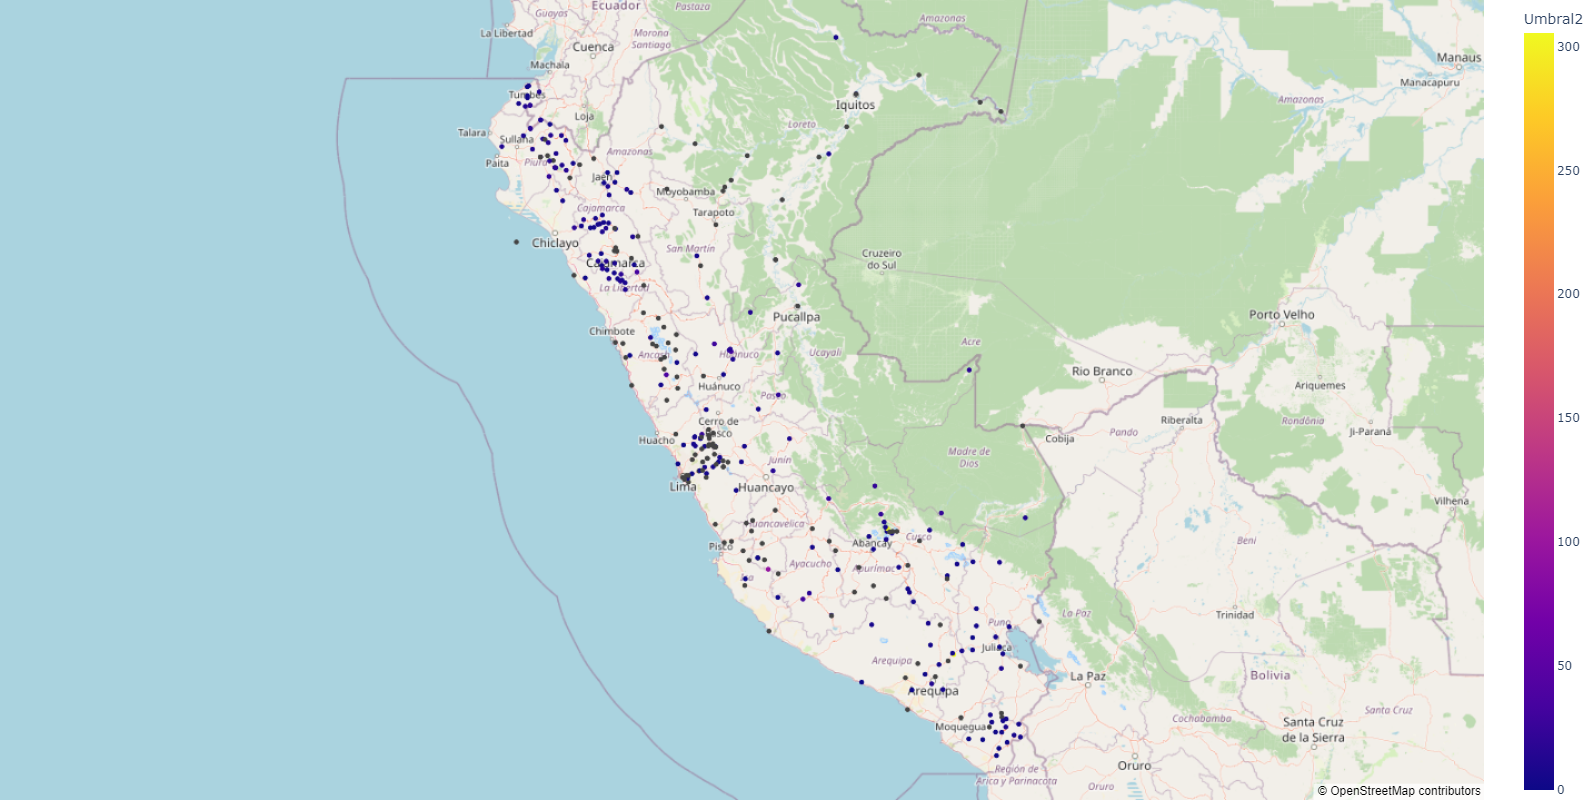

In [18]:
import plotly.express as px
plotMapPrecip(_dfJoined, tipo='')

In [25]:
a = 0.0008
print(f'{a:.2f}%')

0.00%


In [19]:
_dfJoined['difLon'] = abs(_dfJoined['LON'] - -80.397)
_dfJoined['difLat'] = abs(_dfJoined['LAT'] - -4.48047)
_dfJoined['dif'] = _dfJoined['difLon'] + _dfJoined['difLat']

In [20]:
_dfJoined.sort_values('dif', ascending=True).iloc[0]

Unnamed: 0         0.0
ESTACION        ALAMOR
LON          -80.39788
LAT           -4.48047
ALT              116.0
Codigo        47E0D438
Umbral1            9.3
Umbral2           10.2
min1               0.0
min2               0.0
difLon         0.00088
difLat             0.0
dif            0.00088
Name: X47E0D438, dtype: object

In [21]:
_temp = _dfJoined[(abs(_dfJoined['LON'] - -80.397)< 0.01) & ((_dfJoined['LAT'] - -4.48047)<0.01)]
_temp.iloc[0]

Unnamed: 0         0.0
ESTACION        ALAMOR
LON          -80.39788
LAT           -4.48047
ALT              116.0
Codigo        47E0D438
Umbral1            9.3
Umbral2           10.2
min1               0.0
min2               0.0
difLon         0.00088
difLat             0.0
dif            0.00088
Name: X47E0D438, dtype: object

74.5 0.0


<AxesSubplot:>

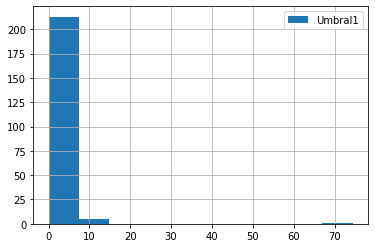

In [22]:
# Estadisticas del FLAGV2
print(dfUmbrales['Umbral1'].max(),dfUmbrales['Umbral1'].min())
dfUmbrales['Umbral1'].hist(legend=True)

305.5 0.0


<AxesSubplot:>

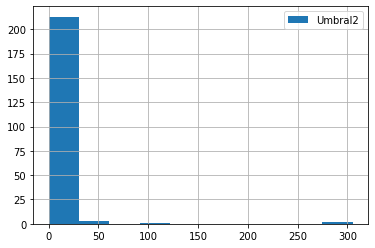

In [23]:
print(dfUmbrales['Umbral2'].max(),dfUmbrales['Umbral2'].min())
dfUmbrales['Umbral2'].hist(legend=True)

In [24]:
#errorsUmbrales = changeUmbralesFileName(DUmbrales)
umbrales, noMayor, errors = getUmbralesResumen(DUmbrales,verb=70)

Se procesaran  219 archivos ...
Progreso: 0.00 % en 0.00s
Progreso: 31.96 % en 0.67s
Progreso: 63.93 % en 1.41s
Progreso: 95.89 % en 2.08s
Tiempo total tomado: 2.16s
Umbrales con valmax1 mayor a valmax2:  0
Umbrales que no se encontraron:        0


In [38]:
# Realizamos el QC para hallar el flagV2
dsCompleto = applyFlagV2([Fdatos2021], umbrales) # Fdatos2020
dsCompleto.to_csv(f'{path_base}/Archivos/Dataset/dsFLAGOOT_20251008.csv')

Se leera los archivos de datasets...
Tiempo tomadoen leer los archivos: 0.28s
Tiempo tomado en procesar el dataset: 2.18s
+Cantidad de datos leidos 97552


In [39]:
dsCompleto['FLAGV2'].unique()

array(['D01', 'D02', 'C01'], dtype=object)

In [40]:
dsCompleto[(dsCompleto['FLAGV2'].isin(['D01', 'D02']))].to_csv(r'C:\Users\Shounen\Desktop\imagenes_tesis\val_nuevo_FlagV2.csv', index=False)

In [41]:
_t = pd.read_csv(r'C:\Users\Shounen\Desktop\imagenes_tesis\val_nuevo_FlagV2.csv')
_t['FLAG'].value_counts() / len(_t) * 100, len(_t)

(C0000002    98.612078
 M0000002     1.387922
 Name: FLAG, dtype: float64,
 74716)

In [42]:
dsCompleto[(dsCompleto['FLAGV2'].isin(['D01', 'D02']))&(dsCompleto['PRECIPITACION']>1)].to_csv(r'C:\Users\Shounen\Desktop\imagenes_tesis\val_nuevo_FlagV2_min1.csv', index=False)

In [43]:
_t = pd.read_csv(r'C:\Users\Shounen\Desktop\imagenes_tesis\val_nuevo_FlagV2_min1.csv')
_t['FLAG'].value_counts() / len(_t) * 100 , len(_t)

(C0000002    99.048731
 M0000002     0.951269
 Name: FLAG, dtype: float64,
 29119)

In [ ]:
# Visualizamos
dsCompleto =pd.read_csv(f'{path_base}/Archivos/Dataset/dsFLAGV2.csv')
dsCompleto.head(5)

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1     codigo  num         dia  \
0             0             0             1  X47E0B1DE    1  06/02/2023   
1             1             1             2  X47E0B1DE    1  06/02/2023   
2             2             2             3  X47E0B1DE    1  06/02/2023   
3             3             3             4  X47E0B1DE    1  09/02/2023   
4             4             4             5  X47E0B1DE    1  09/02/2023   

       hora  valor  Unnamed: 0                ESTACION  ...   XO   XA  \
0  05:00:00    0.2        30.0  PUENTE SIMON RODRIGUEZ  ...  140  347   
1  06:00:00    0.3        30.0  PUENTE SIMON RODRIGUEZ  ...  140  347   
2  07:00:00    0.1        30.0  PUENTE SIMON RODRIGUEZ  ...  140  347   
3  07:00:00    0.5        30.0  PUENTE SIMON RODRIGUEZ  ...  140  347   
4  08:00:00    0.2        30.0  PUENTE SIMON RODRIGUEZ  ...  140  347   

                    imagen    CODIGO                  NOMBRE       FECHA  \
0  140--347--2023-02-06-05  47E0B1DE  PUENTE SIMON RODRIGUEZ  06/02/2023   
1  140--347--2023-02-06-06  47E0B1DE  PUENTE SIMON RODRIGUEZ  06/02/2023   
2  140--347--2023-02-06-07  47E0B1DE  PUENTE SIMON RODRIGUEZ  06/02/2023   
3  140--347--2023-02-09-07  47E0B1DE  PUENTE SIMON RODRIGUEZ  09/02/2023   
4  140--347--2023-02-09-08  47E0B1DE  PUENTE SIMON RODRIGUEZ  09/02/2023   

       HORA  PRECIPITACION      FLAG FLAGV2  
0  05:00:00            0.2  C0000002    D01  
1  06:00:00            0.3  C0000002    D02  
2  07:00:00            0.1  C0000002    D01  
3  07:00:00            0.5  C0000002    D02  
4  08:00:00            0.2  C0000002    D02  

[5 rows x 35 columns]

In [ ]:
dsCompleto[dsCompleto['CODIGO']=='4722A338']

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1     codigo  num         dia  \
55632         55632         55632        142312  X4722A338   12  14/04/2023   
55633         55633         55633        142313  X4722A338   12  14/04/2023   
55634         55634         55634        142314  X4722A338   12  15/04/2023   
55635         55635         55635        142315  X4722A338   12  15/04/2023   
55636         55636         55636        142318  X4722A338   12  15/04/2023   
...             ...           ...           ...        ...  ...         ...   
55859         55859         55859        142976  X4722A338   12  25/02/2024   
55860         55860         55860        142977  X4722A338   12  26/02/2024   
55861         55861         55861        142982  X4722A338   12  26/02/2024   
55862         55862         55862        142995  X4722A338   12  27/02/2024   
55863         55863         55863        143003  X4722A338   12  29/02/2024   

           hora  valor  Unnamed: 0  ESTACION  ...   XO   XA  \
55632  22:00:00    0.1       206.0  ACJANACO  ...  662  809   
55633  23:00:00    0.8       206.0  ACJANACO  ...  662  809   
55634  00:00:00    2.4       206.0  ACJANACO  ...  662  809   
55635  01:00:00    2.3       206.0  ACJANACO  ...  662  809   
55636  14:00:00    0.1       206.0  ACJANACO  ...  662  809   
...         ...    ...         ...       ...  ...  ...  ...   
55859  23:00:00    8.2       206.0  ACJANACO  ...  662  809   
55860  00:00:00    1.4       206.0  ACJANACO  ...  662  809   
55861  09:00:00    0.4       206.0  ACJANACO  ...  662  809   
55862  17:00:00    0.6       206.0  ACJANACO  ...  662  809   
55863  06:00:00    0.4       206.0  ACJANACO  ...  662  809   

                        imagen    CODIGO    NOMBRE       FECHA      HORA  \
55632  662--809--2023-04-14-22  4722A338  ACJANACO  14/04/2023  22:00:00   
55633  662--809--2023-04-14-23  4722A338  ACJANACO  14/04/2023  23:00:00   
55634  662--809--2023-04-15-00  4722A338  ACJANACO  15/04/2023  00:00:00   
55635  662--809--2023-04-15-01  4722A338  ACJANACO  15/04/2023  01:00:00   
55636  662--809--2023-04-15-14  4722A338  ACJANACO  15/04/2023  14:00:00   
...                        ...       ...       ...         ...       ...   
55859  662--809--2024-02-25-23  4722A338  ACJANACO  25/02/2024  23:00:00   
55860  662--809--2024-02-26-00  4722A338  ACJANACO  26/02/2024  00:00:00   
55861  662--809--2024-02-26-09  4722A338  ACJANACO  26/02/2024  09:00:00   
55862  662--809--2024-02-27-17  4722A338  ACJANACO  27/02/2024  17:00:00   
55863  662--809--2024-02-29-06  4722A338  ACJANACO  29/02/2024  06:00:00   

       PRECIPITACION      FLAG FLAGV2  
55632            0.1  C0000002    D01  
55633            0.8  C0000002    D02  
55634            2.4  C0000002    D02  
55635            2.3  C0000002    D02  
55636            0.1  C0000002    D01  
...              ...       ...    ...  
55859            8.2  C0000002    D02  
55860            1.4  C0000002    D01  
55861            0.4  C0000002    D01  
55862            0.6  C0000002    D01  
55863            0.4  C0000002    D01  

[232 rows x 35 columns]

In [ ]:
df_pruebas = pd.read_csv('')